# Importing kaggle credential

In [1]:
!pip install -q kaggle

In [2]:
!kaggle datasets download kitnguynvn/logo-data

Dataset URL: https://www.kaggle.com/datasets/kitnguynvn/logo-data
License(s): apache-2.0
 99% 945M/956M [00:16<00:00, 88.4MB/s]
100% 956M/956M [00:16<00:00, 62.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/logo-data.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import os
import xml.etree.ElementTree as ET

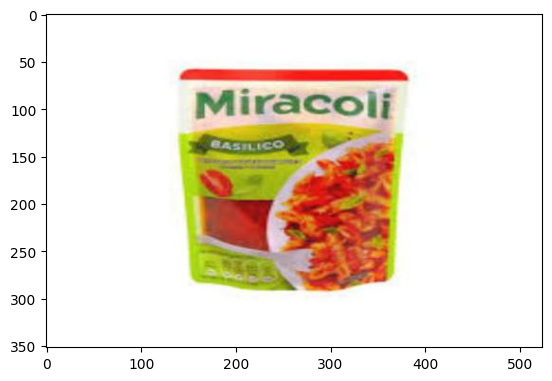

In [6]:
example = '/content/images/Foodmiracoli28.jpg'
img = Image.open(example)
plt.imshow(img)

In [7]:
image_dir = '/content/images'
annotation_dir = '/content/annotations'

# Function to parse XML and extract bounding box data
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_data = []

    # Get image filename and size (assuming standard PASCAL VOC structure)
    filename = os.path.basename(xml_file).replace('.xml', '.jpg')
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        x_min = int(bbox.find('xmin').text)
        y_min = int(bbox.find('ymin').text)
        x_max = int(bbox.find('xmax').text)
        y_max = int(bbox.find('ymax').text)

        image_data.append({
            'image_filename': filename,
            'logo_class': label,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max
        })

    return image_data
# Load all annotations into a DataFrame
annotations = []
for xml_file in os.listdir(annotation_dir):
    if xml_file.endswith('.xml'):
        annotations.extend(parse_annotation(os.path.join(annotation_dir, xml_file)))

df = pd.DataFrame(annotations)

# Display basic information
print("Basic Info of Dataset:")
print(df.info())
print("\nSample Rows:")
print(df.head())

Basic Info of Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60656 entries, 0 to 60655
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filename  60656 non-null  object
 1   logo_class      60656 non-null  object
 2   x_min           60656 non-null  int64 
 3   y_min           60656 non-null  int64 
 4   x_max           60656 non-null  int64 
 5   y_max           60656 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.8+ MB
None

Sample Rows:
               image_filename       logo_class  x_min  y_min  x_max  y_max
0     NecessitiesEscada28.jpg           Escada     70     18    473    360
1  ClothesArmaniExchange8.jpg  Armani Exchange      1     74    338    342
2         FoodBeaulieu131.jpg         Beaulieu     34     38    456    140
3        Foodpanarottis62.jpg      panarotti's      7     59    239    247
4     Necessitiesbrita173.jpg            brita    219    198    359    25

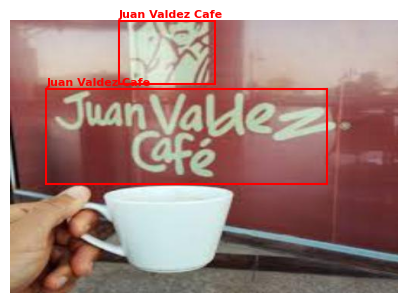

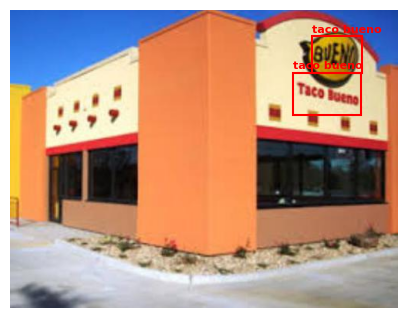

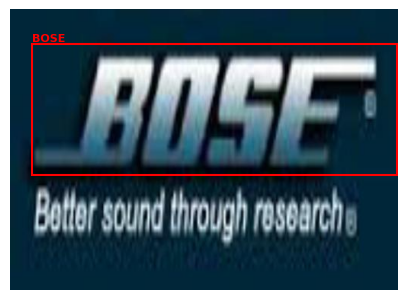

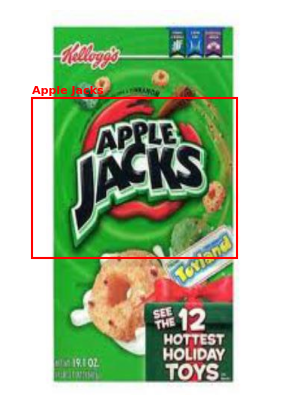

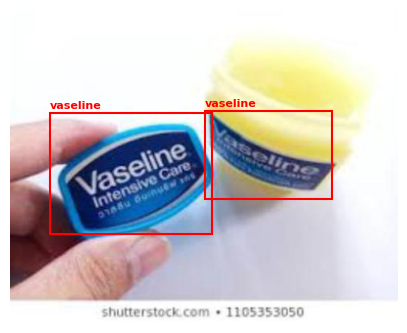

In [8]:
#Plot image with bboxs

def plot_sample_with_bboxes(df, n=5):
    sample_images = df['image_filename'].sample(n).unique()
    for img_name in sample_images:
        img_path = os.path.join(image_dir, img_name)
        img_df = df[df['image_filename'] == img_name]
        with Image.open(img_path) as img:
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            for _, row in img_df.iterrows():
                x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
                plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                                  linewidth=1.5, edgecolor='red', facecolor='none'))
                plt.text(x_min, y_min - 5, row['logo_class'], color='red', fontsize=8, weight='bold')
            plt.axis('off')
            plt.show()

plot_sample_with_bboxes(df, n=5)

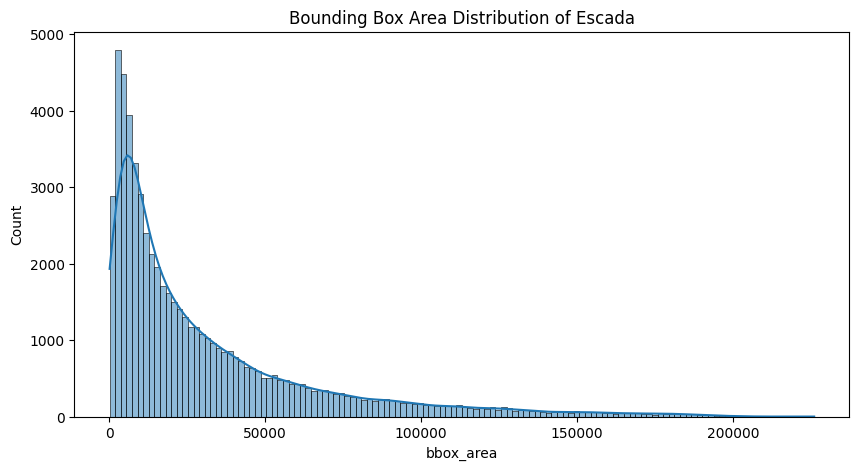

In [9]:
df['bbox_width'] = df['x_max'] - df['x_min']
df['bbox_height'] = df['y_max'] - df['y_min']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']
plt.figure(figsize=(10, 5))
sns.histplot(df['bbox_area'], kde=True)
plt.title(f"Bounding Box Area Distribution of {df['logo_class'][0]}")
plt.show()

Logo Size Distribution:
logo_size
medium    30320
small     15172
large     15164
Name: count, dtype: int64


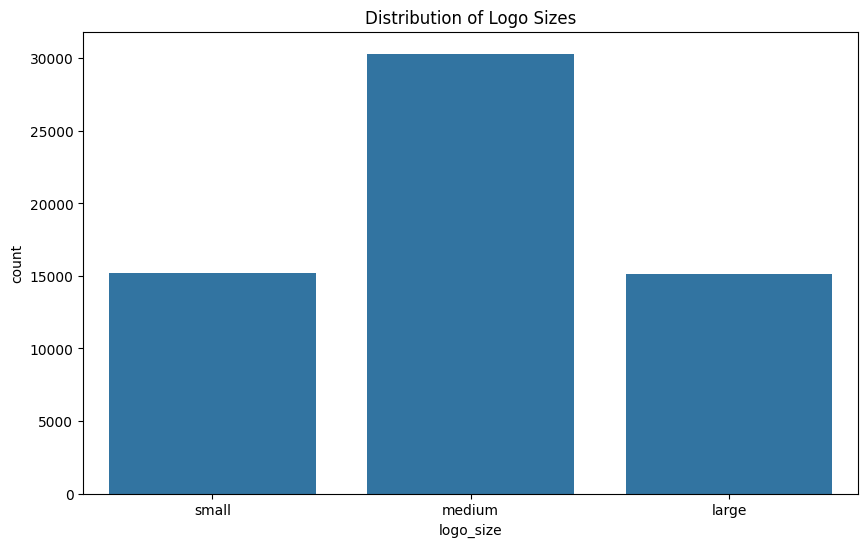

In [10]:


# Calculate the area thresholds for small, medium, and large logos
small_threshold = df['bbox_area'].quantile(0.25)
large_threshold = df['bbox_area'].quantile(0.75)

# Define a function to label each bounding box
def categorize_logo_size(area):
    if area <= small_threshold:
        return 'small'
    elif area <= large_threshold:
        return 'medium'
    else:
        return 'large'

# Apply the function to create a new column in the DataFrame
df['logo_size'] = df['bbox_area'].apply(categorize_logo_size)

# Display the count of each logo size category
print("Logo Size Distribution:")
print(df['logo_size'].value_counts())

# Visualize the distribution of logo sizes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='logo_size', order=['small', 'medium', 'large'])
plt.title("Distribution of Logo Sizes")
plt.show()
